## `Speculator`: NMF-based SFH with burst.

`speculator` takes physical parameters and predict PCA coeffs (see `PCA_components_NMF.ipynb`), spectra, and also magnitudes. 

This notebook takes code from `speculator`: https://github.com/justinalsing/speculator`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import astropy.units as u
import os
os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')
import torch
from torch import Tensor

In [3]:
import sys
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import Speculator, interp_nan

Input parameters : logmstar, beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index

In [4]:
#### 10 params

In [5]:
params = np.concatenate([np.load(f'./train_sed_NMF/fsps.NMF.v0.1.theta_unt.seed{i+1}.npy')
                         for i in range(0, 1)])
params = params[:, 1:] # exclude stellar mass (1 M_\dot), remain redshift (i.e., length of SFH)

wave = np.load('./train_sed_NMF/fsps.wavelength.npy')

In [6]:
params.shape[0]

10000

In [116]:
i_bin = 0

wave_bin = [ 
        (wave >= 1000) & (wave < 2000), 
        (wave >= 2000) & (wave < 3600), 
        (wave >= 3600) & (wave < 5500), 
        (wave >= 5500) & (wave < 7410), 
        (wave >= 7410) & (wave < 60000)
        ][i_bin]
str_wbin = [
        '.w1000_2000', 
        '.w2000_3600', 
        '.w3600_5500', 
        '.w5500_7410', 
        '.w7410_60000' 
        ][i_bin]

transform specs to PCA one by one, avoid memory overflow

In [117]:
logspec = np.concatenate([np.load(f'./train_sed_NMF/fsps.NMF.v0.1.log10spectrum.seed{i+1}{str_wbin}.npy')
                           for i in range(0, 1)])
# logspec = interp_nan(logspec)
# print(logspec.shape)
# # Very large... and slow

In [94]:
# zero_flag = (np.mean(logspec, axis=1) < -40)

# logspec = logspec[~zero_flag]
# params = params[~zero_flag]
# pca_coeff = np.load('./train_sed/fsps.pca_coeffs.npy')[~zero_flag]
# # This zero_flag is SUPER IMPORTANT!!!

In [32]:
fspecs = [f'./train_sed_NMF/fsps.NMF.v0.1.log10spectrum.seed{i+1}{str_wbin}.npy'
                           for i in range(15, 25)]

In [25]:
speculator = Speculator(name='NMF_test', model='NMF', n_parameters=10,
                        pca_filename=f'./train_sed_NMF/fsps.NMF.pca_trained{str_wbin}.pkl', 
                        hidden_size=[256, 256, 256, 256])

In [33]:
pca_coeff = []
for file in fspecs:
    pca_coeff.append(speculator.pca.PCA.transform(speculator.pca.logspec_scaler.transform(np.load(file, mmap_mode='r'))))

In [34]:
pca_coeff = np.concatenate(pca_coeff)
print(pca_coeff.shape)

(1000000, 50)


In [11]:
speculator.load_data(pca_coeff, params, 
                     params_name=['beta1_sfh', 'beta2_sfh', 'beta3_sfh', 'beta4_sfh', 
                                  'fburst', 'tburst', 'logzsol', 
                                  'dust1', 'dust2', 'dust_index', 'redshift'],
                     val_frac=0.1, batch_size=256, 
                     wave_rest=torch.Tensor(wave[wave_bin]), 
                     wave_obs=torch.Tensor(wave[wave_bin]))

train_ind = speculator.dataloaders['train'].dataset.indices
val_ind = speculator.dataloaders['val'].dataset.indices

In [ ]:
%%time
# lrs = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6]
lrs = [5e-4, 1e-4, 5e-5] # 1e-3, 
n_ep = [100 for _ in lrs]
for n, lr in zip(n_ep, lrs): # 3e-4
    speculator.train(learning_rate=lr, n_epochs=n)

Loss = 0.00004 (train), 0.00003 (val), 1.87679 (recon_err):  17%|███████▋                                     | 17/100 [02:01<09:52,  7.14s/epochs]

In [ ]:
lrs = [3e-3, 5e-4, 1e-4]
n_ep = [200, 200, 100] # 500

In [98]:
# %%time
# # n_ep = [100, 100, 150, 500, 500]
# # for i, lr in enumerate([2e-3, 1e-3, 5e-4, 3e-4, 1e-4]):
# n_ep = [200, 200, 200, 200, 200]
# for i, lr in enumerate([2e-3, 1e-3, 5e-4, 3e-4, 2e-4]):
#     speculator.train(learning_rate=lr, n_epochs=n_ep[i])

In [71]:
speculator.best_recon_err_epoch

795

In [72]:
speculator.best_loss_epoch

808

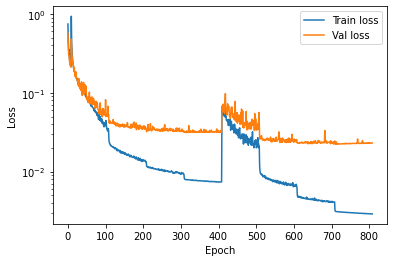

In [69]:
speculator.plot_loss()

In [118]:
## Load the NN emulator `speculator`
with open('./speculator_best_loss_model_NMF.emu_0.pkl', 'rb') as f:
    _speculator = pickle.load(f)

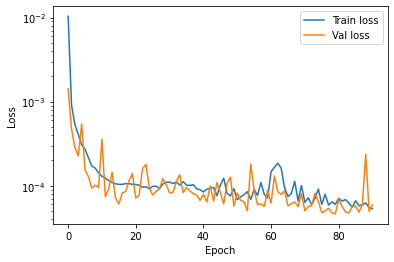

In [119]:
_speculator.plot_loss()

In [120]:
# _specs = speculator.predict_spec(torch.Tensor(params[val_ind]).to('cuda')).cpu().detach().numpy()
_specs = _speculator.predict_spec(torch.Tensor(params).to('cuda')).cpu().detach().numpy()

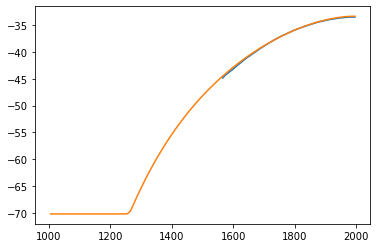

In [127]:
plt.plot(wave[wave_bin], np.log10(_specs)[219])
# plt.plot(wave[wave_bin], logspec[val_ind][529])
plt.plot(wave[wave_bin], logspec[219])

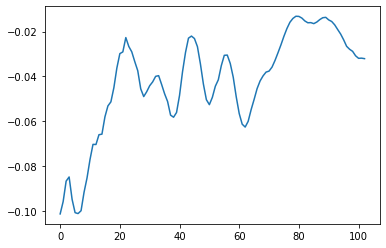

In [122]:
# plt.plot(np.nanmedian(np.log10(_specs) - logspec[val_ind], axis=0))
plt.plot(np.nanmedian(np.log10(_specs) - logspec, axis=0))

In [123]:
# diff = (10**logspec[val_ind] - _specs) / 10**logspec[val_ind] * 100
diff = np.abs(10**logspec - _specs) / 10**logspec# * 100
# diff = (10**logspec - _specs) / 10**logspec* 100
# diff = (logspec[val_ind] - np.log10(_specs)) / logspec[val_ind] * 100

In [124]:
from scipy.stats import norm

In [125]:
# np.where(np.nanmean(diff, axis=1) > 5)

Text(0.5, 0, 'Wavelength [nm]')

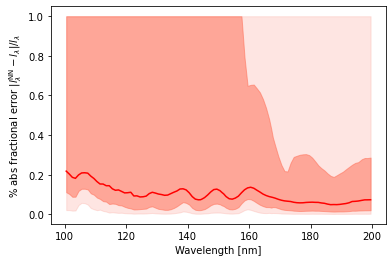

In [126]:
x = wave[wave_bin] / 10
plt.plot(x, np.nanmedian(diff, axis=0), color='r', label='Median')

plt.fill_between(x, 
                 np.nanpercentile(diff, (1 - norm.cdf(1)) * 100, axis=0), 
                 np.nanpercentile(diff, norm.cdf(1) * 100, axis=0), alpha=0.5, color='tomato', label=r'$1\sigma$')

plt.fill_between(x, 
                 np.nanpercentile(diff, (1 - norm.cdf(2)) * 100, axis=0), 
                 np.nanpercentile(diff, norm.cdf(2) * 100, axis=0), alpha=0.2, color='salmon', label=r'$2\sigma$')

plt.ylabel(r'% abs fractional error $|l_{\lambda}^{\mathrm{NN}} - l_{\lambda}|/l_{\lambda}$')
plt.xlabel('Wavelength [nm]')

# plt.xscale('log')
# plt.ylim(0, 0.05)

In [114]:
diff = (10**logspec - _specs) / 10**logspec* 100

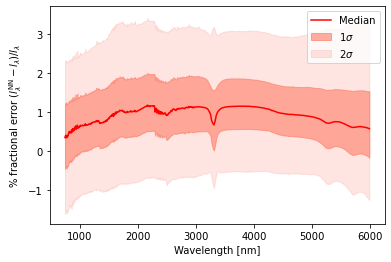

In [115]:
x = wave[wave_bin] / 10
plt.plot(x, np.nanmedian(diff, axis=0), color='r', label='Median')

plt.fill_between(x, 
                 np.nanpercentile(diff, (1 - norm.cdf(1)) * 100, axis=0), 
                 np.nanpercentile(diff, norm.cdf(1) * 100, axis=0), alpha=0.5, color='tomato', label=r'$1\sigma$')

plt.fill_between(x, 
                 np.nanpercentile(diff, (1 - norm.cdf(2)) * 100, axis=0), 
                 np.nanpercentile(diff, norm.cdf(2) * 100, axis=0), alpha=0.2, color='salmon', label=r'$2\sigma$')

# plt.ylim(-5, 5)

plt.ylabel(r'% fractional error $(l_{\lambda}^{\mathrm{NN}} - l_{\lambda})/l_{\lambda}$')
plt.xlabel('Wavelength [nm]')

# plt.hlines(0, 200, 1100, ls='--', color='k')
plt.legend()

# plt.xlim(200, 1100)

In [318]:
from PIL import Image

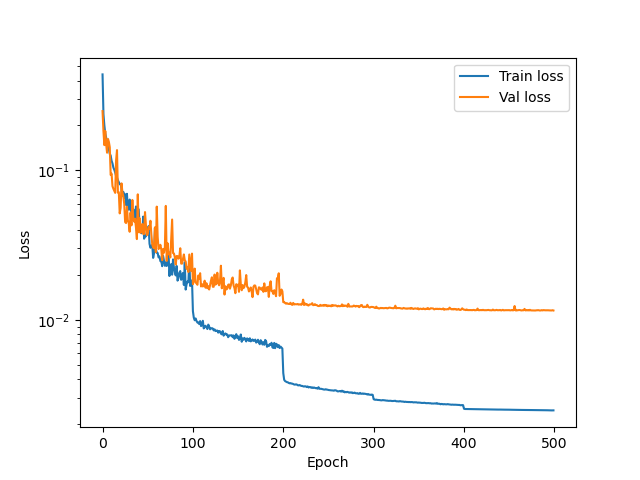

In [20]:
Image.open('./speculator_NMF_4_loss.png')

In [333]:
ls -lhtr

total 3.1G
drwxr-xr-x. 2 jiaxuanl astro 4.0K Oct 30 22:42 train_sed_backup/
-rw-r--r--. 1 jiaxuanl astro 755K Oct 30 22:49 model.pkl
-rw-r--r--  1 jiaxuanl astro 558K Nov  3 13:44 best_model.pth
-rw-r--r--  1 jiaxuanl astro  22M Nov  8 23:25 test.pkl
-rw-r--r--  1 jiaxuanl astro 599K Nov 11 20:46 phot_best_recon_err_model.pkl
-rw-r--r--  1 jiaxuanl astro 600K Nov 11 20:46 phot_best_loss_model.pkl
-rw-r--r--  1 jiaxuanl astro 990K Nov 15 19:54 best_loss_model_nde_nsf.pkl
-rw-r--r--  1 jiaxuanl astro    0 Nov 15 20:56 best_loss_model_KL.pkl
-rw-r--r--  1 jiaxuanl astro 1.1M Nov 28 23:00 best_loss_model_nsf_sinkhorn.pkl
drwxr-xr-x  2 jiaxuanl astro 4.0K Dec  7 21:17 nde_theta_noise_free/
drwxr-xr-x  2 jiaxuanl astro 4.0K Dec  8 00:18 nde_theta_SNR10/
drwxr-xr-x. 2 jiaxuanl astro 4.0K Dec 16 16:42 reference_catalog/
drwxr-xr-x. 2 jiaxuanl astro 4.0K Dec 16 17:57 noise_model/
drwxr-xr-x  2 jiaxuanl astro 4.0K Dec 16 21:47 nde_theta_SNR10_new/
drwxr-xr-x  2 jiaxuanl astro 4.0K Jan 25 16:31 n

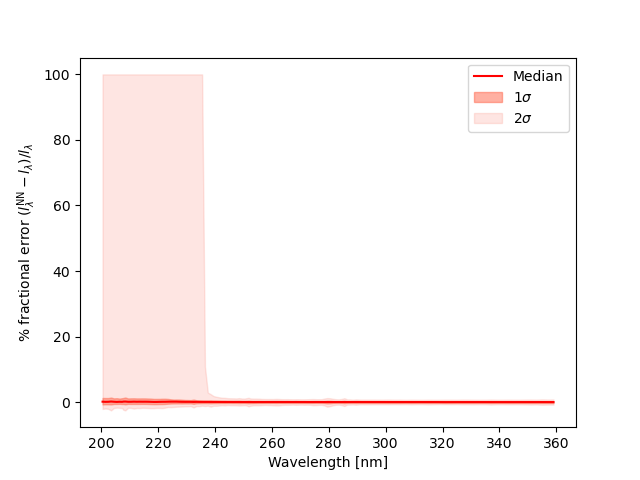

In [334]:
Image.open('./NMF_emulator_.w2000_3600_frac_err.png')